The Hamiltonian for the Ising model is given by:
$$
    \mathcal{H}=J\sum_{i=1}^{n} \sigma_{i}^{x} \sigma_{i+1}^{x}+ h\sum_{i=1}^{n} \sigma_{i}^{z}.
$$
i.e.
$$
    \mathcal{H}= B + A. 
$$

where $B = \sum_{i=1}^{n} B_j$, $B_j = e^{-i(J\sigma_{i}^{x}\sigma_{i+1}^{x})\Delta t}$ and $A =\sum_{i=1}^{n} A_j$, $A_j = e^{-i(h \sigma^z_i)\Delta t}$

We will use Trotter decomposition to simulate the time evolution of this Hamiltonian given by the operator $U = e^{-i\mathcal{H}t}$. Since the operators A and B do not commute, we cannot exactly express the exponential of a sum as a product of the exponential. Using Baker-Campbell-Housdorff:
$$
e^{-i \mathcal{H} t}=e^{-i A t} e^{-i B t}+\mathcal{O}\left(t^{2}\right)
$$


Now, we discretize time and the evolution become a  product of discrete evolution operations: 
$$
U(t) = \underbrace{U(\Delta t) \cdots U(\Delta t)}_{N \, times}
$$
i.e. 
$$
e^{-i\mathcal{H}t} = (e^{-i\mathcal{H} \Delta t})^N
$$
where $\Delta t$ = t/M and M is the number of Trotter steps. Since the Hamiltonian commutes with itself, this equation is exact. The time evolution operator for a discrete step can be written as:
$$
e^{-i \mathcal{H} \Delta t}=\left(\prod_{j} A_{j}\right)\left(\prod_{j \text { even }} B_{j}\right)\left(\prod_{j o d d} B_{j}\right)+\mathcal{O}\left((\Delta t)^{2}\right)
$$

If we want to evolve the system to time $t=M \Delta t$, the error is $\mathcal{O}\left((\Delta t)\right)$, thus the error can be decreased by decreasing the size of the Trotter step. Such accuracy will come at a price of implementing a larger number of gates. By using higher order Suzuki-Trotter decomposition, more symmetric product of the exponentials can be obtained which will reduce the error further, we will continute with the basic Trotterization for simplicity.

$A_j$ is simply a rotation around z-axis whereas $B_j$ is a two-qubit unitary which can be implemented by using the following identity[3]:
$$C X_{j, k} e^{-i \sigma_{j}^{X} t} C X_{j, k}=e^{-i \sigma_{j}^{X} \sigma_{k}^{X} t}$$

In [4]:
from qiskit import *
import matplotlib.pyplot as plt

#Circuit implementation of A_j which is rotation around z-axis by angle h.dt
def A(qc, h, dt, j):
    qc.rz(h*dt, j)

#Circuit implementation of B_j based on the above identity    
def B(qc, J, dt, j):
    qc.cx(j,j+1)
    qc.rx(J*dt,j)
    qc.cx(j,j+1)    

We will take n=4 and consider the time evolution of $| \uparrow \uparrow \uparrow \uparrow >$ state. In IBM Q, the initial state is always $| \uparrow >$, so we don't need to do anything to the initialized qubit.

In [127]:
n = 4
J = 1
dt = 0.25
t  = dt
circuit = QuantumCircuit(n,n)
for i in range(n):
    A(circuit,h,dt,i)

for i in range(int(n/2)):
    B(circuit,J,dt,2*i)

for i in range(int(n/2)-1):
    B(circuit,J,dt,i+1)

Lets visualize our quantum circuit to see if we are doing exactly what we want to do.

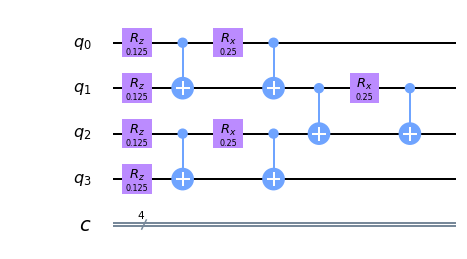

In [8]:
circuit.draw(output='mpl')

After simulating the time evolution, we want to plot the magnetization vs time, so we need a function to calculate the magnetization of the given state.

In [13]:
def mag(n):
    num_str = str(n)
    sum = 0
    for i in range(0, len(num_str)):
        sum += int(num_str[i])
    return sum

In [131]:
from qiskit.tools.visualization import plot_histogram
simulator = Aer.get_backend('qasm_simulator')
hlist=[0.5,0.9,1.8] 
magt_sim = [[] for _ in range(len(hlist))]
shots= 1024
def Circuit_t(n_steps,dt,h,J,n):
    circuit = QuantumCircuit(n,n)
    for i in range(n_steps):
        for j in range(n):
            A(circuit,h,dt,j)

        for j in range(int(n/2)):
            B(circuit,J,dt,2*j)

        for j in range(int(n/2)-1):
            B(circuit,J,dt,j+1)
        
        circuit.barrier()
    circuit.measure(range(n),range(n))
    return circuit
        

N = 50
for j in range(len(hlist)):
    h = hlist[j]
    t_list = []
    for i in range(N):    
        t_list.append(i*dt)
        ct = Circuit_t(i,dt,h,J,n)
        result = execute(ct,backend=simulator,shots=shots).result()
        res=result.get_counts()
        r1=list(res.keys())
        r2=list(res.values())
        M=0
        for k in range(0,len(r1)):
            M=M+(n-2*mag(r1[k]))*r2[k]/shots
        magt_sim[j].append(M/n)
#plot_histogram(ct.get_counts())
#print(ct.get_counts())

Here's a plot of the time evolution for |↑↑↑↑> state.

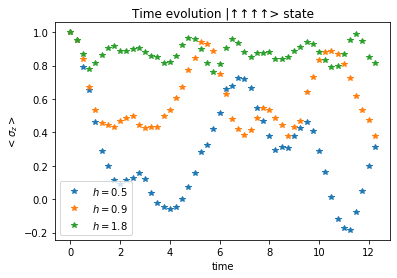

In [137]:
plt.plot(t_list,magt_sim[0],"*",label='$h=0.5$')
plt.plot(t_list,magt_sim[1],"*",label='$h=0.9$')
plt.plot(t_list,magt_sim[2],"*",label='$h=1.8$')
plt.xlabel('time')
plt.ylabel('$<\sigma_{z}>$')
plt.legend()
plt.title('Time evolution |↑↑↑↑> state')
plt.show()

## References
1. Smith, A., Kim, M. S., Pollmann, F., & Knolle, J. Simulating quantum many-body dynamics on a current digital quantum computer. https://doi.org/10.1038/s41534-019-0217-0
2. Hatano, N. & Suzuki, M. Finding exponential product formulas of higher orders. in Lect.Notes Phys 679,37–68 (2005)

3. https://quantumcomputing.stackexchange.com/questions/6338/how-to-implement-the-xy-heisenberg-interaction-using-ibmq-and-qiskit?rq=1